In [1]:
import numpy as np
from imports import *
from MMGKS_OF import *

Tomo = Tomography()

/home/jrudi/Documents/Projects/2025 Dynamic inverse problems with neural nets/code/OF_NSF_2025_Pasha_Rudi/trips/utilities/io.py:126: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if ('noise_level' in kwargs) and noise_level is not 0:


In [2]:
#Specify the shape of the images, the number of images in the sequence and load the image sequence using the gen_seq_function
ny = nx = 64
shape = (nx,ny)
size = nx*ny
t_end = 10

v_max = 1
v_min = 1
padding = 1
data = gen_im_seq(shape,t_end,v_max=v_max,v_min=v_min, padding=padding)
u_traj = data.u_traj
u_inv_traj = data.u_inv_traj
v_primes = data.v_primes
vs = data.vs

# A list of the locations of all pixels
R = np.array(list(np.ndindex(*shape)))
# u_traj = [u*10 for u in u_traj]

plt.set_cmap('inferno')
# u_traj_ = np.load('mnist_test_seq.npy')[:,0,:,:][0:t_end]#*10
# u_traj = [vec(u) for u in u_traj_]
# u_inv_traj=u_traj[::-1]

# v_max = 3

<Figure size 640x480 with 0 Axes>

i=0 u_traj[i].shape=(4096,)
i=1 u_traj[i].shape=(4096,)
i=2 u_traj[i].shape=(4096,)
i=3 u_traj[i].shape=(4096,)
i=4 u_traj[i].shape=(4096,)
i=5 u_traj[i].shape=(4096,)
i=6 u_traj[i].shape=(4096,)
i=7 u_traj[i].shape=(4096,)
i=8 u_traj[i].shape=(4096,)
i=9 u_traj[i].shape=(4096,)


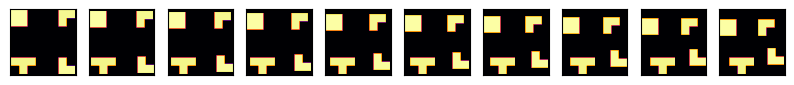

In [3]:
fig,ax=plt.subplots(1,t_end,figsize=(10,5))
for i in range(0,t_end):
    print(f"{i=} {u_traj[i].shape=}")
    ax[i].imshow(u_traj[i].reshape(shape))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Case: A; Views:5; NL:1%

In [4]:
#Generate the sinogram and the operator
views = 5
noise_level = 1e-2
x_traj = u_traj

X_true, A_bar,data_vec_bar,data_vec_true_bar,b_shape,L_bar, I_bar,deltas = gen_joint_tomo_op_and_data(x_traj, t_end, nx,ny, views,
                                                                           noise_level, case='a')
b_size = b_shape[0]*b_shape[1]
delta = np.mean(deltas) #la.norm(data_vec_true_bar-data_vec_bar)
print(delta)

[  0.  36.  72. 108. 144.]
[  3.6  39.6  75.6 111.6 147.6]
[  7.2  43.2  79.2 115.2 151.2]
[ 10.8  46.8  82.8 118.8 154.8]
[ 14.4  50.4  86.4 122.4 158.4]
[ 18.  54.  90. 126. 162.]
[ 21.6  57.6  93.6 129.6 165.6]
[ 25.2  61.2  97.2 133.2 169.2]
[ 28.8  64.8 100.8 136.8 172.8]
[ 32.4  68.4 104.4 140.4 176.4]
2.9014660358428954


Text(0.5, 0.98, 'Noisy sinograms of the images in the sequence')

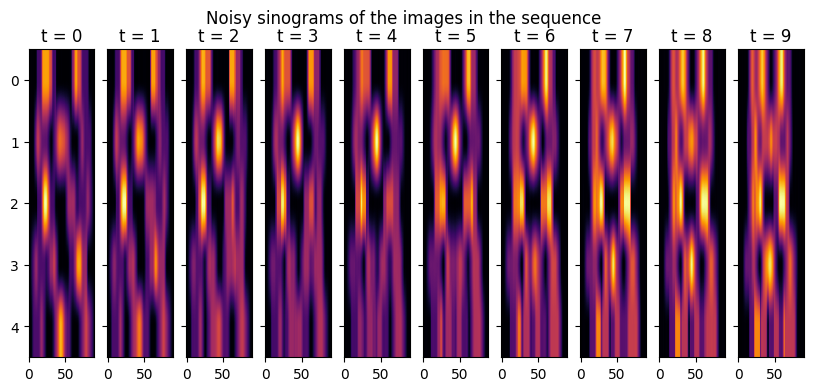

In [5]:
fig,ax=plt.subplots(1,t_end, sharey=True, figsize=(10,4))
data_vec_bar_list_c = [data_vec_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
data_vec_true_bar_list_c = [data_vec_true_bar[b_size*i:b_size*(i+1)] for i in range(t_end)]
for i in range(0,t_end):
    ax[i].imshow(data_vec_bar_list_c[i].reshape(b_shape),aspect='auto')
    ax[i].set_title(f't = {i}')
fig.suptitle('Noisy sinograms of the images in the sequence')

In [7]:
from imports import *
from trips.solvers.MMGKS import *

n_iter = 100
n_iter_b = 20
proj_dim = 3
vs_true = None #vs 
v_primes_true= None #v_primes 
reduction = True
scale = 1
epsilon=1e-1
non_neg = True #False
L_space_time = gen_spacetime_derivative_operator(nx,ny,t_end)

In [12]:
# MMGKS

(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)

#ANISO_TV
# nt=t_end
# L = gen_spacetime_derivative_operator(nx, ny, nt)
# (X_ANISO_TV, info_ANISO_TV) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
#                                 regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, prob_dims = (nx,ny, nt),delta=delta)
# error_ANISO_TV = info_ANISO_TV['relError'][-1]
# X_ANISO_TV[X_ANISO_TV<0]=0
# X_ANISO_TV_list = [X_ANISO_TV[size*i:size*(i+1)] for i in range(t_end)]
# print('ANISO_TV Solution relative error:', error_ANISO_TV)


#GS
nt=t_end
L = gen_spacetime_derivative_operator(nx, ny, nt)
(X_GS, info_GS) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, GS= 'gs', prob_dims = (nx,ny, nt),delta=delta)
error_GS = info_GS['relError'][-1]
X_GS[X_GS<0]=0
X_GS_list = [X_GS[size*i:size*(i+1)] for i in range(t_end)]
print('GS Solution relative error:', error_GS)


# L = gen_spacetime_derivative_operator(nx, ny, nt)
# (X_ISO_TV, info_ISO_TV) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
#                                 regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, isoTV= 'isoTV', prob_dims = (nx,ny, nt),delta=delta)
# error_ISO_TV = info_ISO_TV['relError'][-1]
# X_ISO_TV[X_ISO_TV<0]=0
# X_ISO_TV_list = [X_ISO_TV[size*i:size*(i+1)] for i in range(t_end)]
# print('ISO_TV Solution relative error:', error_ISO_TV)




# X_mm_of,info_mm_of,_,_ =  MMGKS_OF(A_bar, data_vec_bar.reshape((-1,1)), L_bar,t_end,shape,pnorm=2, qnorm=1, rnorm = 1, projection_dim=proj_dim,
#                                       n_iter = n_iter, regparam = 'dp',
#                                        x0=None, V0 = None,v_ests_0=None,x_true=X_true.reshape((-1,1)),power=0.5,two_way=True,kmin=proj_dim,l_max =200,interval = 10,non_neg=True,epsilon=1e-2,start_of=10, parallel_of=True, delta = delta, use_true_of = False)

# error_mm_of = info_mm_of['relError'][-1]

# X_mm_of[X_mm_of<0]=0
# X_mm_of_list = [X_mm_of[size*i:size*(i+1)] for i in range(t_end)]

# print('MMGKS-OF Solution relative error:', error_mm_of)

running MMGKS...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


MMGKS Solution relative error: 0.43401756481949266


running MMGKS...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


GS Solution relative error: 0.4973953775869103


running MMGKS...:   0%|                                                                                                                                            | 0/100 [00:00<?, ?it/s]/home/jrudi/.pyenv/versions/optflow/lib/python3.9/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
running MMGKS...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:22<00:00,  6.22s/it]

Dynamic MMGKS Solution relative error: 0.35619696274262197


In [8]:
## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est, M_history, x_history, v_ests_history, ux_history, uy_history, ux_uy_history, ut_history) = \
    MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
                     qnorm=1, rnorm=1, projection_dim=proj_dim, 
                     n_iter =n_iter, n_iter_b = n_iter_b, 
                     regparam = 'dp', regparam_dyn = 'dp',
                     vs_true = vs_true, v_primes_true=v_primes_true,  v_max=2, 
                     x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,
                     epsilon=epsilon,delta =delta,pnorm_opt=2, qnorm_opt=2,non_neg=non_neg,
                     interval = 1)



error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']

X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)

running MMGKS...:   0%|                                     | 0/100 [00:00<?, ?it/s]/home/jrudi/.pyenv/versions/optflow/lib/python3.9/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
running MMGKS...: 100%|███████████████████████████| 100/100 [10:28<00:00,  6.29s/it]

Dynamic MMGKS Solution relative error: 0.35619696274262197


In [10]:
print(f"{np.array(x_history).shape=}")
print(f"{np.array(ux_history).shape=}")
print(f"{np.array(uy_history).shape=}")
#print(f"{np.array(ux_uy_history).shape=}")
print(f"{np.array(ut_history).shape=}")
print(f"{np.array(v_ests_history).shape=}")

np.array(x_history).shape=(101, 40960, 1)
np.array(ux_history).shape=(100, 9, 4096)
np.array(uy_history).shape=(100, 9, 4096)
np.array(ut_history).shape=(100, 9, 4096)
np.array(v_ests_history).shape=(100, 9, 64, 64, 2)


In [12]:
dtype = np.float32
u_history_array = np.empty((n_iter+1, t_end, nx, ny), dtype=dtype)
ux_history_array = np.empty((n_iter, t_end-1, nx, ny), dtype=dtype)
uy_history_array = np.empty((n_iter, t_end-1, nx, ny), dtype=dtype)
ut_history_array = np.empty((n_iter, t_end-1, nx, ny), dtype=dtype)
vx_history_array = np.empty((n_iter, t_end-1, nx, ny), dtype=dtype)
vy_history_array = np.empty((n_iter, t_end-1, nx, ny), dtype=dtype)

for i, u_it in enumerate(x_history):
    for k in range(t_end):
        u_history_array[i,k,:] = u_it[nx*ny*k:nx*ny*(k+1)].reshape(nx, ny).astype(dtype)
    
for i, (ux_it, uy_it, ut_it, v_it) in enumerate(zip(ux_history, uy_history, ut_history, v_ests_history)):
    for k, (ux_ts, uy_ts, ut_ts, v_ts) in enumerate(zip(ux_it, uy_it, ut_it, v_it)):        
        ux_history_array[i,k,:] = ux_ts.reshape(nx, ny).astype(dtype)
        uy_history_array[i,k,:] = uy_ts.reshape(nx, ny).astype(dtype)
        ut_history_array[i,k,:] = ut_ts.reshape(nx, ny).astype(dtype)
        vx_history_array[i,k,:] = v_ts[:,:,0].astype(dtype)
        vy_history_array[i,k,:] = v_ts[:,:,1].astype(dtype)
        
    #break ###DEV###

In [13]:
import pathlib

save_dir = pathlib.Path("./2025-12-10a_mmgks_dyn_joint")
save_dir.mkdir(exist_ok=True)

np.save(f"{save_dir / 'u_history.npy'}", u_history_array)
np.save(f"{save_dir / 'ux_history.npy'}", ux_history_array)
np.save(f"{save_dir / 'uy_history.npy'}", uy_history_array)
np.save(f"{save_dir / 'ut_history.npy'}", ut_history_array)
np.save(f"{save_dir / 'vx_history.npy'}", vx_history_array)
np.save(f"{save_dir / 'vy_history.npy'}", vy_history_array)

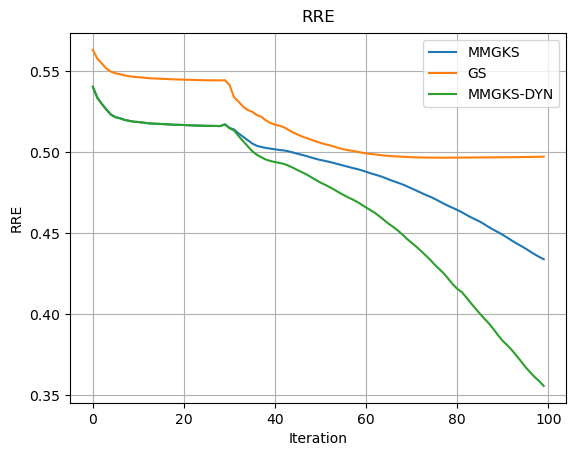

In [10]:
plt.plot(info_mmgks['relError'],label='MMGKS')
plt.plot(info_GS['relError'],label='GS')
plt.plot(info_mmgks_dyn['relError'],label='MMGKS-DYN')
plt.xlabel('Iteration') 
plt.grid('minor')
plt.ylabel('RRE')
plt.legend()
plt.title('RRE',va='bottom');

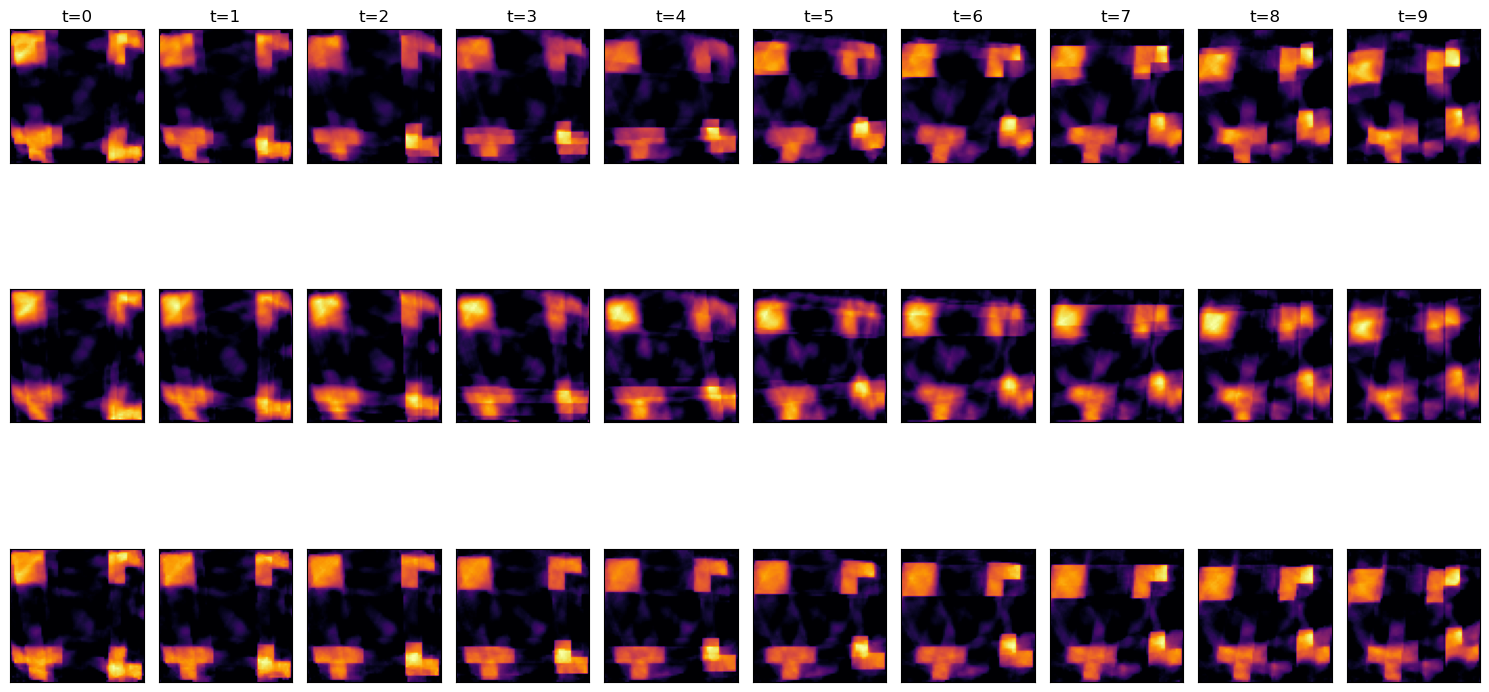

In [12]:
fig,ax=plt.subplots(3,t_end,figsize=(15,9),sharex=True, sharey=True)
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
#     rec_list.append(next_)
for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[2,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[1,i].imshow(X_GS_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
plt.subplots_adjust(wspace=None, hspace=None)
fig.tight_layout(h_pad=1)
# fig.suptitle('Recovered Solutions to the Regularized Problem '  + '(Top Row: Recovered with MMGKS;' + 
#                 ' Middle Row: Recovered with TV-ISO;'   + 
#              ' Bottom Row: Recovered with Dynamic MMGKS)' + '\n' );

In [13]:
print('RRE_MMGKS',rre_all(X_mmgks,np.array(u_traj),nt,nx,ny))
print('RRE_MMGKS_DYN',rre_all(X_mmgks_dyn,np.array(u_traj),nt,nx,ny))
print('RRE_GS',rre_all(X_GS,np.array(u_traj),nt,nx,ny))
print('SSIM_MMGKS',ssim_all(X_mmgks,np.array(u_traj),nt,nx,ny))
print('SSIM_MMGKS_DYN',ssim_all(X_mmgks_dyn,np.array(u_traj),nt,nx,ny))
print('SSIM_GS',ssim_all(X_GS,np.array(u_traj),nt,nx,ny))

RRE_MMGKS 0.4334270242228112
RRE_MMGKS_DYN 0.3540833693666824
RRE_GS 0.4641634689957688
SSIM_MMGKS 0.8451632177935393
SSIM_MMGKS_DYN 0.8984847336726098
SSIM_GS 0.8178317163741493


In [26]:
case_a_folder = 'example_1'
# np.save(f'{case_a_folder}/X_mmgks.npy',X_mmgks)
# np.save(f'{case_a_folder}/X_mmgks_dyn.npy',X_mmgks_dyn)
# np.save(f'{case_a_folder}/X_GS.npy',X_GS)
# np.save(f'{case_a_folder}/relError_mmgks.npy',info_mmgks['relError'])
# np.save(f'{case_a_folder}/relError_mmgks_dyn.npy',info_mmgks_dyn['relError'])
# np.save(f'{case_a_folder}/relError_GS.npy',info_GS['relError'])
# np.save(f'{case_a_folder}/regParam_mmgks.npy',info_mmgks['regParam_history'])
# np.save(f'{case_a_folder}/regParam_mmgks_dyn.npy',info_mmgks_dyn['regParam_history'])
# np.save(f'{case_a_folder}/regParam_GS.npy',info_GS['regParam_history'])

In [27]:
# np.save(f'{case_a_folder}/M_history.npy',M_history)
# np.save(f'{case_a_folder}/v_ests_history.npy',v_ests_history)
# np.save(f'{case_a_folder}/ux_uy_history.npy',ux_uy_history)
# np.save(f'{case_a_folder}/ut_history.npy',ut_history)

In [28]:
24/25

0.96